<a href="https://colab.research.google.com/github/Aditya3392/Classification-of-Galaxy-Type/blob/main/g_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2

# # Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Define dataset directory and parameters
image_size = (256, 256)
batch_size = 32
num_classes = 3  # Three classes: elliptical, spiral, irregular

train_path = r'/content/drive/MyDrive/train_data_2'
test_path = r'/content/drive/MyDrive/test_data_2'

# Data Augmentation and Preprocessing
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load and split the dataset
train_data = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

test_data = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 3047 images belonging to 3 classes.
Found 268 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])
# Display the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 2915395 (11.12 MB)
Trainable params: 288

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=20, validation_data=test_data, steps_per_epoch=50)


Epoch 1/20
50/50 [==============================] - 65s 824ms/step - loss: 0.2903 - accuracy: 0.8994 - val_loss: 7.7255 - val_accuracy: 0.5187
Epoch 2/20
50/50 [==============================] - 39s 777ms/step - loss: 0.3404 - accuracy: 0.8794 - val_loss: 20.6665 - val_accuracy: 0.4216
Epoch 3/20
50/50 [==============================] - 40s 786ms/step - loss: 0.2798 - accuracy: 0.9048 - val_loss: 16.5784 - val_accuracy: 0.4515
Epoch 4/20
50/50 [==============================] - 41s 820ms/step - loss: 0.2414 - accuracy: 0.9156 - val_loss: 17.7295 - val_accuracy: 0.5187
Epoch 5/20
50/50 [==============================] - 38s 762ms/step - loss: 0.2399 - accuracy: 0.9187 - val_loss: 7.8015 - val_accuracy: 0.5709
Epoch 6/20
48/50 [===========================>..] - ETA: 1s - loss: 0.2328 - accuracy: 0.9115

In [ ]:
# Save the model for future use
model.save('galaxy_model.h5')

1/1 [==============================] - 0s 68ms/step


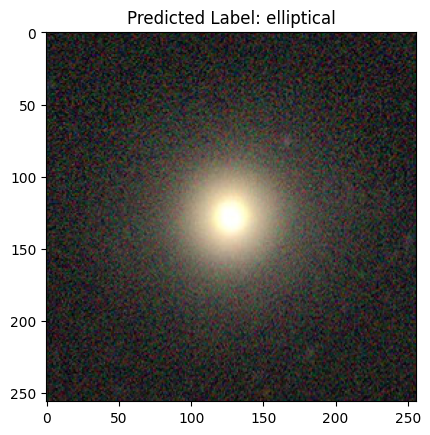

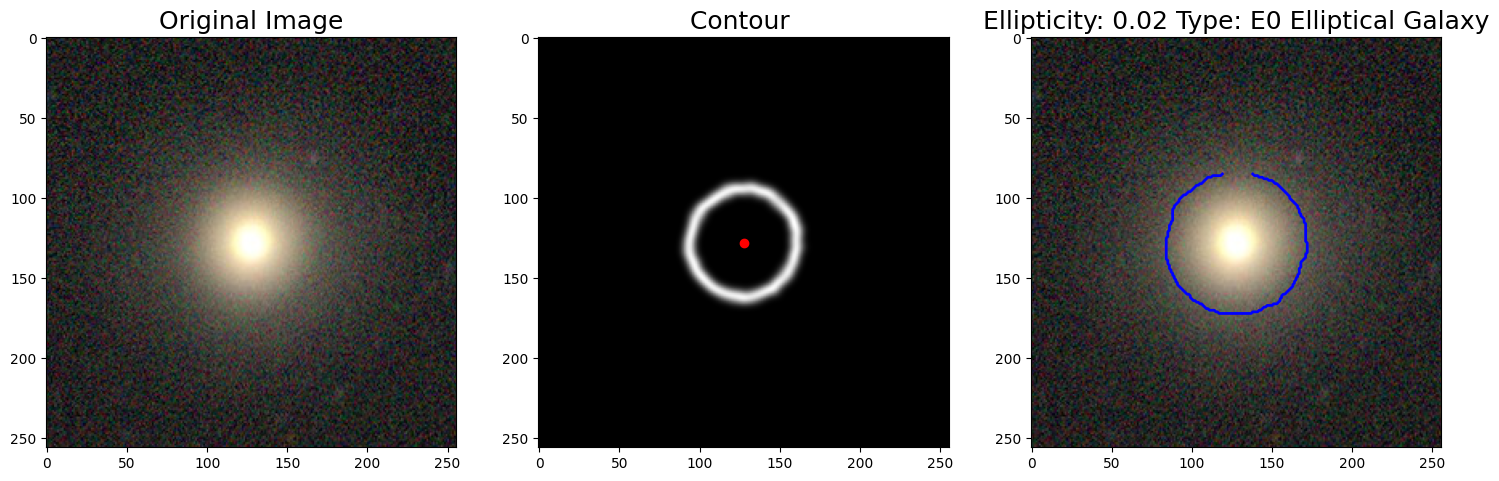

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_image(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    return img

# Load an example galaxy image for prediction
example_image_path = r'/content/image_4702.png'
img_array = [load_image(example_image_path)]
example_image = cv2.imread(example_image_path, cv2.IMREAD_COLOR)
example_image = cv2.resize(example_image, (256, 256))
example_image = example_image / 255.0
example_image = np.reshape(example_image, (1, 256, 256, 3))

# Make predictions on the example image
prediction = model.predict(example_image)

# Define class names
class_names = ['elliptical', 'irregular', 'spiral']

# Decode the predicted label
predicted_label = class_names[np.argmax(prediction)]

# Display the result
plt.imshow(cv2.cvtColor(cv2.imread(example_image_path), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

# For elliptical
if predicted_label == 'elliptical':
    # Elliptical subclassification code
    def load_image(image_path):
        # Load the image using OpenCV
        img = cv2.imread(image_path)
        return img

    img_array = [load_image(example_image_path)]
    # Additional image processing: Edge detection using Sobel
    gray = cv2.cvtColor(img_array[0], cv2.COLOR_BGR2GRAY)

    # Normalize pixel values to be in the range [0, 1]
    gray = cv2.normalize(gray, None, 0, 1, cv2.NORM_MINMAX)

    # Sobel operator in x and y directions
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)

    # Compute the magnitude of the gradient
    edges = np.sqrt(sobelx**2 + sobely**2)

    # Further smoothing using GaussianBlur
    smoothed_img = cv2.GaussianBlur(edges, (15, 15), 0)

    # Find contours in the smoothed edges
    contours, _ = cv2.findContours((smoothed_img * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    if contours:
        max_contour = max(contours, key=cv2.contourArea)

        # Fit an ellipse to the largest contour
        ellipse = cv2.fitEllipse(max_contour)

        # Get the semi-major and semi-minor axes lengths directly
        semi_major_axis = ellipse[1][0]
        semi_minor_axis = ellipse[1][1]

        # Corrected ellipticity calculation
        if semi_major_axis > semi_minor_axis:
            ellipticity = 1 - semi_minor_axis / semi_major_axis
        else:
            ellipticity = 1 - semi_major_axis / semi_minor_axis

        # Classification based on ellipticity
        if ellipticity < 0.1:
            galaxy_type = "E0 Elliptical Galaxy"
        elif 0.1 <= ellipticity <= 0.5:
            galaxy_type = "E3 Elliptical Galaxy"
        else:
            galaxy_type = "E7 Elliptical Galaxy"

        # Plot the images with the detected ellipse
        plt.figure(figsize=(18, 6))

        # Plot the original image
        plt.subplot(131)
        plt.imshow(cv2.cvtColor(img_array[0], cv2.COLOR_BGR2RGB))
        plt.title('Original Image',fontsize=18)

        # Plot the smoothed edges with the detected ellipse in blue color
        plt.subplot(132)
        plt.imshow(smoothed_img, cmap='gray')
        cv2.ellipse(smoothed_img, ellipse, (0, 0, 255), 2)
        plt.scatter(ellipse[0][0], ellipse[0][1], c='r', marker='o', label='Center')
        plt.title('Contour ',fontsize=18)

        # Plot the contour on the original image
        plt.subplot(133)
        plt.imshow(cv2.cvtColor(img_array[0], cv2.COLOR_BGR2RGB))
        plt.plot(max_contour[:, 0, 0], max_contour[:, 0, 1], color='b', linewidth=2)
        plt.title(f'Ellipticity: {ellipticity:.2f} Type: {galaxy_type}',fontsize=18)

        plt.show()

# For spiral
elif predicted_label == 'spiral':
    def load_image(image_path):
        # Load the image using OpenCV
        img = cv2.imread(image_path)
        return img

    def calculate_ellipticity(ellipse):
        # Calculate ellipticity as the ratio of the semi-minor axis to the semi-major axis
        semi_major_axis = ellipse[1][0]
        semi_minor_axis = ellipse[1][1]

        if semi_major_axis > semi_minor_axis:
            ellipticity = 1 - semi_minor_axis / semi_major_axis
        else:
            ellipticity = 1 - semi_major_axis / semi_minor_axis

        return ellipticity

    img_array = [load_image(example_image_path)]
    # Additional image processing: Edge detection using Sobel
    gray = cv2.cvtColor(img_array[0], cv2.COLOR_BGR2GRAY)

       # Apply thresholding to emphasize the brightest regions
_, thresholded_img = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Find contours in the thresholded image
contours, _ = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with the largest area (bulge)
        # Find the contour with the largest area (bulge)
if contours:
    max_contour = max(contours, key=cv2.contourArea)

    # Fit an ellipse to the largest contour (bulge)
    ellipse = cv2.fitEllipse(max_contour)

    # Plot the images with the detected ellipse
    plt.figure(figsize=(18, 6))

    # Plot the original image
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(img_array[0], cv2.COLOR_BGR2RGB))
    plt.title('Original Image',fontsize=16)

    # # Plot the thresholded image with the detected ellipse in blue color
    # plt.subplot(132)
    #  plt.imshow(thresholded_img, cmap='gray')
    # cv2.ellipse(thresholded_img, ellipse, (0, 0, 255), 2)

    # Plot the contour on the original image
    plt.subplot(132)
    plt.imshow(cv2.cvtColor(img_array[0], cv2.COLOR_BGR2RGB))
    plt.plot(max_contour[:, 0, 0], max_contour[:, 0, 1], color='b', linewidth=2)

    # Identify lower brightness parts (arms) connected to the bulge
    lower_brightness_threshold = 150  # Adjust as needed
    _, arms_mask = cv2.threshold(gray, lower_brightness_threshold, 255, cv2.THRESH_BINARY)

    # Combine the arms mask with the thresholded image
    arms_mask = cv2.bitwise_and(arms_mask, cv2.bitwise_not(thresholded_img))

    # Find contours in the arms mask
    contours_arms, _ = cv2.findContours(arms_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Plot additional contours (arms)
    for contour in contours_arms:
        # Filter out small contours (adjust the area threshold as needed)
        if cv2.contourArea(contour) > 50:
            plt.plot(contour[:, 0, 0], contour[:, 0, 1], color='r', linewidth=1)

    # Identify third level of lower brightness parts (spiral arms)
    third_brightness_threshold = 50  # Adjust as needed
    _, third_level_mask = cv2.threshold(gray, third_brightness_threshold, 255, cv2.THRESH_BINARY)

    # Combine the third level mask with the arms mask
    third_level_mask = cv2.bitwise_and(third_level_mask, cv2.bitwise_not(arms_mask))

    # Find contours in the third level mask
    contours_third_level, _ = cv2.findContours(third_level_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Plot additional contours (third level) with the same color as the arms
    for contour in contours_third_level:
        # Filter out small contours (adjust the area threshold as needed)
        if cv2.contourArea(contour) > 10:
            plt.plot(contour[:, 0, 0], contour[:, 0, 1], color='r', linewidth=1)

    # Calculate ellipticity for the bulge
    bulge_ellipticity = calculate_ellipticity(ellipse)

    # Calculate ellipticity for the third level contours (arms)
    if len(contours_third_level) > 0 and len(contours_third_level[0]) >= 5:
        third_ellipse = cv2.fitEllipse(contours_third_level[0])  # Assuming there is only one significant third level contour
        third_ellipticity = calculate_ellipticity(third_ellipse)
    else:
        third_ellipticity = 0  # Set a default value if there are not enough points

    # Calculate the difference in ellipticity
    ellipticity_difference = np.abs(bulge_ellipticity - third_ellipticity)

    # Set a threshold for the difference in ellipticity
    ellipticity_threshold = 0.4  # Adjust as needed

    # Check if the difference in ellipticity exceeds the threshold
    if ellipticity_difference > ellipticity_threshold:
        galaxy_type = "Barred Spiral Galaxy"
    else:
        # Calculate ellipticity for the second level contours (arms)
        if len(contours_arms) > 0 and len(contours_arms[0]) >= 5:
            arms_ellipse = cv2.fitEllipse(contours_arms[0])  # Assuming there is only one significant arm contour
            arms_ellipticity = calculate_ellipticity(arms_ellipse)
        else:
            arms_ellipticity = 0  # Set a default value if there are not enough points

        # Set a threshold for the ellipticity of the second level contours
        second_level_ellipticity_threshold = 0.4  # Adjust as needed

        # Check if the ellipticity of the second level contours exceeds the threshold
        if arms_ellipticity > second_level_ellipticity_threshold:
            galaxy_type = "Barred Spiral Galaxy(Sb)"
        else:
            galaxy_type = "Normal Spiral Galaxy(Sa)"

    plt.title(f' {galaxy_type}',fontsize=16)

    plt.show()
